<a href="https://colab.research.google.com/github/Alialtinel/aalto_summer24_project/blob/main/median_income_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import folium

!pip install shap
import shap

!pip install plotly
import plotly.express as px
import numpy as np


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


from sklearn.cluster import KMeans


In [26]:
acces_token = 'access_token_here'
! git config --global user.email "alialtinel02@gmail.com"
! git config --global user.name "Alialtinel"

In [27]:
!git clone https://{acces_token}@github.com/Alialtinel/aalto_summer24_project.git

fatal: destination path 'aalto_summer24_project' already exists and is not an empty directory.


In [28]:
!git pull

fatal: not a git repository (or any of the parent directories): .git


In [29]:
dir = '/content/aalto_summer24_project/data/filtered_data.csv'
df = pd.read_csv(dir)
df.head()

,LIBGEO,CODGEO,NBMENFISC,NBPERSMENFISC,MED,PIMP,TP60,TP60AGE1,TP60AGE2,TP60AGE3,...,PPSOC,PPFAM,PPMINI,PPLOGT,PIMPOT,D1,D9,RD,lat,lng
0,Paris,001,5064161.67,12386964.00,22911.38,64.53,15.33,19.07,16.30,17.57,...,4.40,1.90,1.37,1.13,-21.93,10580.38,46401.56,4.38,48.8567,2.3522
1,Bordeaux,006,527937.00,1196274.67,21900.44,56.13,12.03,22.30,13.37,13.10,...,4.97,1.83,1.77,1.37,-17.77,11760.29,38424.44,3.28,44.8400,-0.5800
2,Marseille - Aix-en-Provence,003,734905.67,1705454.83,20635.56,53.13,18.63,27.37,21.70,21.97,...,6.57,2.20,2.53,1.80,-18.33,9878.33,38467.78,3.88,NaN,NaN
3,Lyon,002,939886.67,2231507.83,22157.60,58.20,12.87,19.67,14.57,15.00,...,5.17,2.30,1.50,1.33,-18.07,11502.95,40109.42,3.50,45.7600,4.8400
4,Toulouse,004,561315.67,1279804.83,22424.28,57.20,12.47,22.90,13.03,13.33,...,5.23,1.97,1.80,1.47,-18.03,11589.07,39787.93,3.43,43.6045,1.4440


In [30]:
df.shape

(331, 31)

In [31]:

df_clean = df.dropna(subset=['lat', 'lng'])
map_center = [df_clean['lat'].mean(), df_clean['lng'].mean()]
my_map = folium.Map(location=map_center, zoom_start=10)

# Add markers for each LIBGEO
for _, row in df_clean.iterrows():
    folium.Marker(
        location=[row['lat'], row['lng']],
        popup=row['LIBGEO'],
    ).add_to(my_map)

# Save the map as an HTML file
output_file = '/content/aalto_summer24_project/visualizations/libgeo_map.html'
my_map.save(output_file)

print(f"Map saved to {output_file}")

Map saved to /content/aalto_summer24_project/visualizations/libgeo_map.html


In [32]:

# Create the map, setting the scope to France
fig = px.scatter_geo(
    df,
    lat='lat',
    lon='lng',
    size='MED',
    color='MED',
    color_continuous_scale=px.colors.sequential.Plasma,  # Choose a color scale
    hover_name='LIBGEO',
    projection="natural earth",
    scope='europe'  # 'europe' includes France; 'france' is not directly supported
)

fig.update_geos(
    lataxis_range=[41, 51],  # Latitude range to focus on France
    lonaxis_range=[-5, 9]    # Longitude range to focus on France
)

fig.update_layout(
    title='Mean MED by LIBGEO',
    geo=dict(showframe=False, showcoastlines=False),
    coloraxis_colorbar=dict(title="MED")
)

fig.show()


In [33]:
fig_dist = px.histogram(df, x='MED', title='Distribution of MED')
fig_dist.show()

In [53]:
mean_med = df['MED'].mean()
std_med = df['MED'].std()

# Define outlier threshold (e.g., 2 standard deviations away from the mean)
threshold = 2

# Identify outliers
outliers = df[abs(df['MED'] - mean_med) > threshold * std_med]

print("Mean MED:", mean_med)
print("\nOutliers:")
outliers[['LIBGEO', 'MED']].sort_values(by='MED')


Mean MED: 19986.784108761327

Outliers:


,LIBGEO,MED
177,Saint-Louis,12777.20
196,Saint-Louis,12777.20
272,Fourmies,15315.78
327,Hirson,15564.71
195,Saint-Loup-sur-Semouse,16152.56
28,Saint-Denis,16188.98
221,Beaucaire,16540.38
256,Noyon,16575.46
316,Joigny,16697.89
244,Caudry,16738.65


In [34]:
# Select only numeric columns
numeric_df = df.select_dtypes(include='number')

# Calculate the correlation matrix for numeric variables
correlation_matrix = numeric_df.corr()

# Sort the correlation values with 'MED' in descending order
sorted_correlation = correlation_matrix['MED'].sort_values(ascending=False)

mapping_df = pd.read_excel('/content/aalto_summer24_project/data/french_poverty_urban_areas_column_mapping.xlsx')
mapping_df.set_index('column code')


pd.DataFrame(sorted_correlation).merge(mapping_df, left_index=True, right_on='column code')


,MED,column name,column code
4,1.000000,Median Standard of Living (€),MED
5,0.943566,Percentage of Taxable Households,PIMP
26,0.857840,1st Decile of Standard of Living (€),D1
27,0.848453,9th Decile of Standard of Living (€),D9
16,0.376243,Percentage from Salaries and Wages,PTSA
15,0.365537,Percentage of Income from Work,PACT
20,0.314649,Percentage from Property and Other Sources,PPAT
2,0.194680,Number of Tax Households,NBMENFISC
3,0.187708,Number of People in Tax Households,NBPERSMENFISC
18,0.160718,Percentage from Non-Salaried Work Income,PBEN


In [35]:

numeric_df = df.select_dtypes(include='number')

# Fill NaN values with the median of each column
df_filled = numeric_df.fillna(numeric_df.median())

# Display the first few rows of the DataFrame with filled NaN values
df_filled.head()


,NBMENFISC,NBPERSMENFISC,MED,PIMP,TP60,TP60AGE1,TP60AGE2,TP60AGE3,TP60AGE4,TP60AGE5,...,PPSOC,PPFAM,PPMINI,PPLOGT,PIMPOT,D1,D9,RD,lat,lng
0,5064161.67,12386964.00,22911.38,64.53,15.33,19.07,16.30,17.57,16.00,12.10,...,4.40,1.90,1.37,1.13,-21.93,10580.38,46401.56,4.38,48.8567,2.3522
1,527937.00,1196274.67,21900.44,56.13,12.03,22.30,13.37,13.10,11.50,7.40,...,4.97,1.83,1.77,1.37,-17.77,11760.29,38424.44,3.28,44.8400,-0.5800
2,734905.67,1705454.83,20635.56,53.13,18.63,27.37,21.70,21.97,19.23,12.73,...,6.57,2.20,2.53,1.80,-18.33,9878.33,38467.78,3.88,45.7667,3.4267
3,939886.67,2231507.83,22157.60,58.20,12.87,19.67,14.57,15.00,12.37,8.07,...,5.17,2.30,1.50,1.33,-18.07,11502.95,40109.42,3.50,45.7600,4.8400
4,561315.67,1279804.83,22424.28,57.20,12.47,22.90,13.03,13.33,11.50,8.10,...,5.23,1.97,1.80,1.47,-18.03,11589.07,39787.93,3.43,43.6045,1.4440


In [36]:
model_columns = ['NBMENFISC', 'NBPERSMENFISC',  'PIMP', 'TP60', 'TP60AGE1', #'MED',
       'TP60AGE2', 'TP60AGE3', 'TP60AGE4', 'TP60AGE5', 'TP60AGE6', 'TP60TOL1',
       'TP60TOL2', 'PACT', 'PTSA', 'PCHO', 'PBEN', 'PPEN', 'PPAT', 'PPSOC',
       'PPFAM', 'PPMINI', 'PPLOGT', 'PIMPOT', 'D1', 'D9', 'RD' ]#'lat', 'lng'

# Assuming 'MED' is the target variable and all other numeric columns are features
X = df_filled[model_columns]
y = df_filled['MED']

# Split the data into training and testing sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the linear regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the training and testing data
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Evaluate the model
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # Mean Absolute Percentage Error
    return mse, r2, mae, mape

# Evaluate on training set
mse_train, r2_train, mae_train, mape_train = evaluate_model(y_train, y_train_pred)
print("Training Set:")
print("MSE:", mse_train)
print("R-squared:", r2_train)
print("MAE:", mae_train)
print("MAPE:", mape_train, "%")

# Evaluate on testing set
mse_test, r2_test, mae_test, mape_test = evaluate_model(y_test, y_test_pred)
print("\nTesting Set:")
print("MSE:", mse_test)
print("R-squared:", r2_test)
print("MAE:", mae_test)
print("MAPE:", mape_test, "%")


Training Set:
MSE: 15725.945469968832
R-squared: 0.99244556322322
MAE: 92.25432601647924
MAPE: 0.4607255825940071 %

Testing Set:
MSE: 42319.378633796674
R-squared: 0.9872493980251467
MAE: 142.7145052578844
MAPE: 0.7645008941881812 %


In [37]:
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
})

# Merge with column mapping to get column names
coefficients_with_names = coefficients.merge(mapping_df, left_on='Feature', right_on='column code')

coefficients_with_names[['Feature',	'Coefficient'	,'column name'	]]

,Feature,Coefficient,column name
0,NBMENFISC,0.009651,Number of Tax Households
1,NBPERSMENFISC,-0.003924,Number of People in Tax Households
2,PIMP,110.615637,Percentage of Taxable Households
3,TP60,-154.121558,Overall Poverty Rate
4,TP60AGE1,-0.131700,Poverty Rate - Under 30 Years
5,TP60AGE2,0.038820,Poverty Rate - 30 to 39 Years
6,TP60AGE3,-32.748384,Poverty Rate - 40 to 49 Years
7,TP60AGE4,26.339992,Poverty Rate - 50 to 59 Years
8,TP60AGE5,5.090916,Poverty Rate - 60 to 74 Years
9,TP60AGE6,2.499172,Poverty Rate - 75 Years or Older


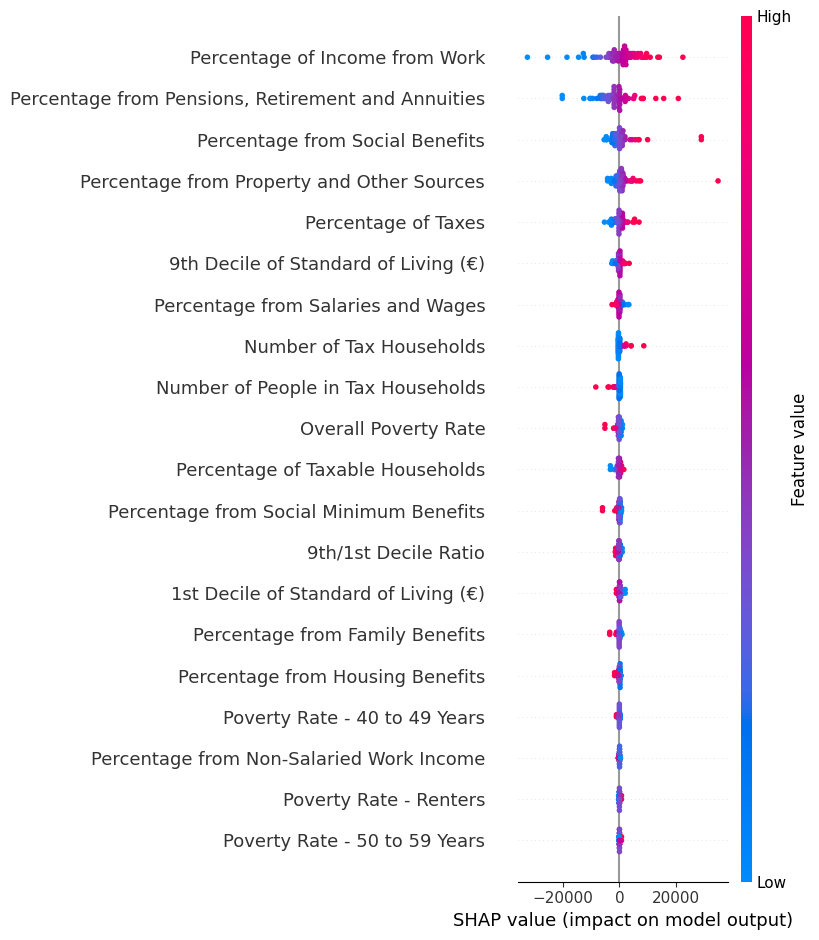

In [38]:
# Fits the explainer
explainer = shap.Explainer(model.predict, X_train)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, feature_names=coefficients_with_names['column name'])


In [6]:
%cd aalto_summer24_project

!git pull

[Errno 2] No such file or directory: 'aalto_summer24_project'
/content/aalto_summer24_project
Already up to date.


In [54]:
# Save the DataFrame to a CSV file


# Add the file to the Git repository
!git add .

# Commit the changes
!git commit -m "added visualizations"

# Push the changes to the remote repository
!git push origin main


/content/aalto_summer24_project
[main a1480ad] added visualizations
 1 file changed, 6477 insertions(+)
 create mode 100644 visualizations/libgeo_map.html
To https://github.com/Alialtinel/aalto_summer24_project.git
 ! [rejected]        main -> main (fetch first)
error: failed to push some refs to 'https://github.com/Alialtinel/aalto_summer24_project.git'
hint: Updates were rejected because the remote contains work that you do
hint: not have locally. This is usually caused by another repository pushing
hint: to the same ref. You may want to first integrate the remote changes
hint: (e.g., 'git pull ...') before pushing again.
hint: See the 'Note about fast-forwards' in 'git push --help' for details.
